In [1]:
%matplotlib inline  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='darkgrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import *
#import random
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle
from efficientnet_pytorch import EfficientNet
import pretrainedmodels
from albumentations import *
import time

In [2]:
base_image_dir1 = '2015data/'
train_dir1 = os.path.join(base_image_dir1, 'resized_train_cropped/')
df1 = pd.read_csv(os.path.join(base_image_dir1, 'trainLabels_cropped.csv'))
df1['path'] = df1['image'].map(lambda x: os.path.join(train_dir1,'{}.jpeg'.format(x)))
df1 = df1.drop(columns=['image', 'Unnamed: 0', 'Unnamed: 0.1'])
df1 = df1.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df1.head(10)

,level,path
0,0,2015data/resized_train_cropped/42552_left.jpeg
1,1,2015data/resized_train_cropped/11443_left.jpeg
2,2,2015data/resized_train_cropped/14626_right.jpeg
3,1,2015data/resized_train_cropped/26796_right.jpeg
4,0,2015data/resized_train_cropped/23102_right.jpeg
5,2,2015data/resized_train_cropped/33580_right.jpeg
6,0,2015data/resized_train_cropped/8827_right.jpeg
7,1,2015data/resized_train_cropped/4830_left.jpeg
8,2,2015data/resized_train_cropped/27076_left.jpeg
9,0,2015data/resized_train_cropped/6458_right.jpeg


In [3]:
base_image_dir2 = '2019data/'
train_dir2 = os.path.join(base_image_dir2,'train_images/')
df2 = pd.read_csv(os.path.join(base_image_dir2, 'train.csv'))
df2['path'] = df2['id_code'].map(lambda x: os.path.join(train_dir2,'{}.png'.format(x)))
df2 = df2.drop(columns=['id_code'])
df2 = df2.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df2.columns = ['level', 'path']

df2.head(10)

,level,path
0,0,2019data/train_images/c98f623d08d1.png
1,0,2019data/train_images/4e85aa647534.png
2,0,2019data/train_images/3580a545016d.png
3,2,2019data/train_images/e12b67835e03.png
4,0,2019data/train_images/43823561c3f0.png
5,0,2019data/train_images/3079490a4b9c.png
6,0,2019data/train_images/1d37f1c8b6d8.png
7,0,2019data/train_images/a0adbe677508.png
8,0,2019data/train_images/767d777ee889.png
9,0,2019data/train_images/09237bf783a4.png


There are 38770 images


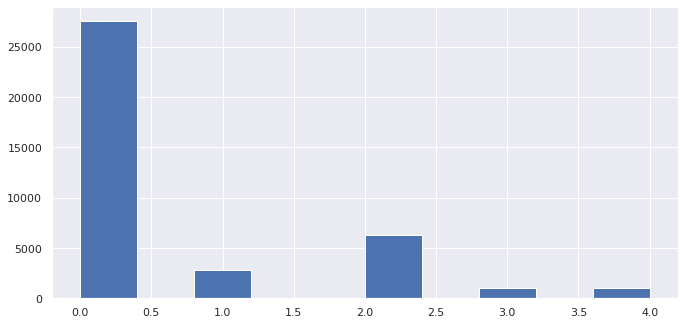

In [4]:
df = pd.concat([df1, df2], ignore_index=True)
len_df = len(df)
print(f"There are {len_df} images")
df['level'].hist(figsize = (10, 5))

1024 840


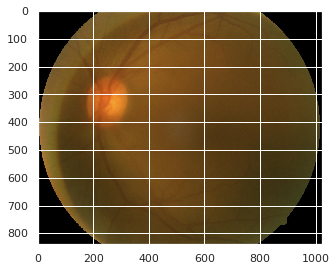

In [5]:
idx = 2457
im = Image.open(df['path'][idx])
width, height = im.size
print(width,height) 
im.show()
plt.imshow(np.asarray(im))

In [6]:
# Batch size. Increase/Decrease upon GPU capacity
# Smaller batch size is better for training, but may take longer
bs = 48
# Image Dimension
sz=224

In [7]:
def show_image(image,figsize=None,title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
#     else: # crash!!
#         fig = plt.figure()
        
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
        
    if title is not None:
        plt.title(title)

def show_Nimages(imgs,scale=1):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)

'''Use case from https://www.kaggle.com/alexanderliao/image-augmentation-demo-with-albumentation/'''
def albaugment(aug0, img):
    return aug0(image=img)['image']

def apply_album(img, sz):
    IMG_SIZE = (sz,sz)

    '''3. Random Crop and then Resize'''
    #w2h_ratio = aspect ratio of cropping
    # aug3 = RandomSizedCrop((h_min, h_max),IMG_SIZE[1],IMG_SIZE[0], w2h_ratio=IMG_SIZE[0]/IMG_SIZE[1],p=1)
    aug3 = CenterCrop(np.round(img.shape[0]*0.75).astype(int), np.round(img.shape[1]*0.75).astype(int))
    
    final_aug = OneOf([
        # aug1,aug2,
        aug3
        # ,aug4, aug5
    ],p=0.5)

    return final_aug(image=img)['image']

## Ben's preprocess

In [8]:
def crop_image(img,tol=7):        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def open_aptos2019_image(fn, convert_mode, after_open)->Image:
    SIZE = sz
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = crop_image(image)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image , (0,0) , SIZE/10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))
    
def load_ben_color(fn, convert_mode, after_open)->Image:
    sigmaX=10
    IMG_SIZE = sz
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return Image(pil2tensor(image, np.float32).div_(255))

def load_ben_color_pre(fn, aug=True):
    sigmaX=10
    IMG_SIZE = sz
    image = cv2.imread(fn)
    if aug==True:
        image = apply_album(image, IMG_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

def open_aptos2019_image_pre(fn):
    SIZE = sz
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = crop_image(image)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image , (0,0) , SIZE/10) ,-4 ,128)
    return image

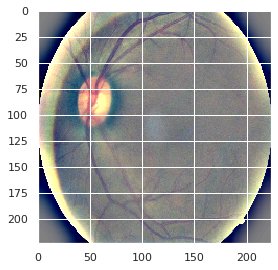

In [9]:
preprocessed_img = load_ben_color_pre(df['path'][idx])
plt.imshow(preprocessed_img)

In [112]:
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = load_ben_color_pre(fn.replace('/./','').replace('//','/'))
        # img, flag = crop_image_ilovescience(fn.replace('/./','').replace('//','/'))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32).div_(255))

In [113]:
val_idx = [i for i in range(len(df1), len(df))]

In [114]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.2,max_lighting=0.5,p_lighting=0.5)
src = (MyImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        # .split_by_rand_pct(0.1) #Splitting the dataset
       .split_by_idx(val_idx)
        .label_from_df(cols='level',label_cls=FloatList) #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

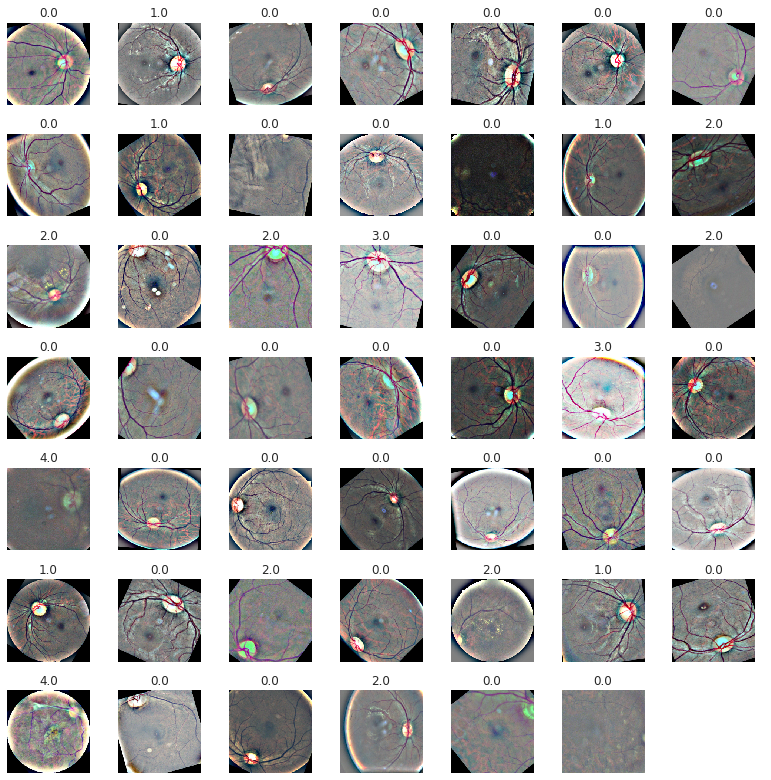

In [81]:
data.show_batch(rows=8, figsize=(11,11))

In [115]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat.cpu()), y.cpu(), weights='quadratic'), device='cuda:0')

In [116]:
model_name = 'efficientnet-b2' # change b5 to b0-b7 for different versions of EfficientNet
model = EfficientNet.from_pretrained(model_name, num_classes=1)
learn = Learner(data, model, metrics = [quadratic_kappa], model_dir='models')

Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,quadratic_kappa,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.91E-07


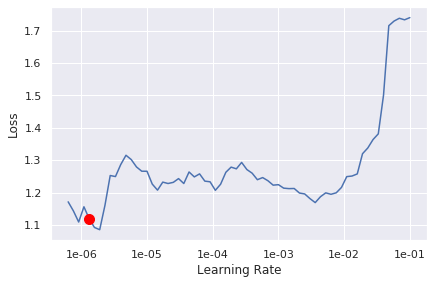

In [117]:
stage = 1
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [118]:
csvlogger = callbacks.CSVLogger(learn=learn, filename='history_stage_'+str(stage))
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                        monitor='quadratic_kappa', mode='max',
                                        name='stage_'+str(stage)+'_bestmodel_'+model_name+str(sz)+'_mse')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)

In [119]:
lr = 1e-3 #Put your learning rate here 1e-2.
learn.fit_one_cycle(15, max_lr = lr, callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.649487,0.557828,0.783015,08:58
1,0.560853,0.411298,0.848016,08:56
2,0.561249,0.551736,0.846444,08:56
3,0.511959,0.961634,0.765390,08:59
4,0.476934,0.526413,0.840209,08:57
5,0.460746,0.592294,0.826654,08:57
6,0.436826,0.515602,0.848904,08:58
7,0.396681,0.439787,0.857885,08:58
8,0.377367,0.487850,0.870766,08:57
9,0.369362,0.491043,0.844699,08:57


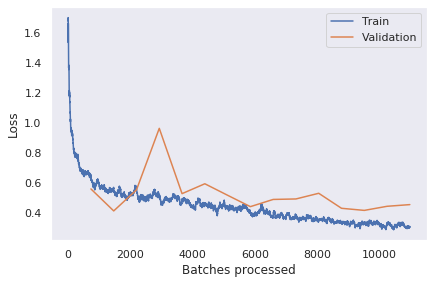

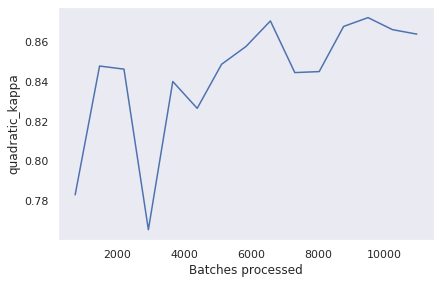

In [120]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [87]:
stage = 2
learn.unfreeze()

csvlogger = callbacks.CSVLogger(learn=learn, filename='history_stage_'+str(stage))
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                        monitor='quadratic_kappa', mode='max',
                                        name='stage_'+str(stage)+'_bestmodel_'+model_name+str(sz)+'_mse')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)
learn.load('stage_'+str(1)+'_bestmodel_' + model_name+str(sz)+'_mse_4')

Learner(data=ImageDataBunch;

Train: LabelList (35108 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
0.0,1.0,2.0,1.0,0.0
Path: .;

Valid: LabelList (3662 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
0.0,0.0,0.0,2.0,0.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, ep

epoch,train_loss,valid_loss,quadratic_kappa,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 4.79E-07


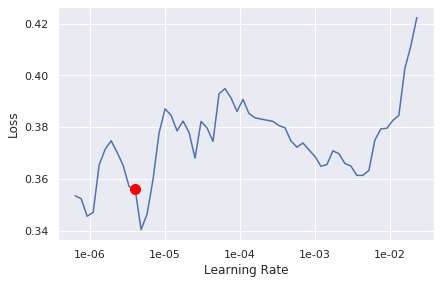

In [88]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

## Training stage2

In [92]:
lr = 1e-4 #Put your learning rate here.
learn.fit_one_cycle(10, max_lr = slice(lr), callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.391732,0.480015,0.852556,09:05
1,0.361655,0.461614,0.851023,09:07
2,0.366960,0.504026,0.852152,09:06
3,0.349093,0.460388,0.857506,09:03
4,0.359815,0.428129,0.858472,09:01
5,0.362743,0.485129,0.858240,09:01
6,0.346717,0.477980,0.847546,09:02
7,0.326768,0.450888,0.858106,09:01
8,0.328656,0.457908,0.857765,09:01
9,0.333976,0.469191,0.856754,09:03


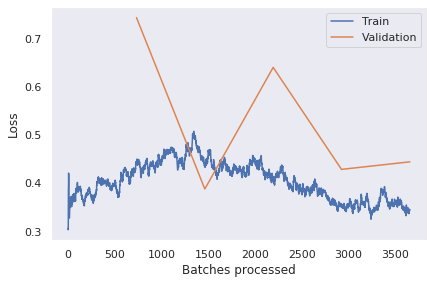

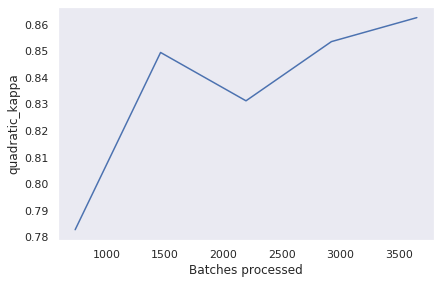

In [60]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [121]:
best_val_loss_idx = 12 # epoch number on which the lowest val_loss occured 
best_model = 'stage_'+str(1)+'_bestmodel_'+model_name+str(sz)+'_mse_'+str(best_val_loss_idx)

# Phase 2 Training

In [122]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=24)
print(skf.get_n_splits(df2))
train_idx, val_idx = None, None
for train_index, test_index in skf.split(df2, df2['level']):
    train_idx, val_idx =  train_index, test_index
    break

5


In [123]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.2,max_lighting=0.5,p_lighting=0.5, p_affine=0.5)
src = (MyImageItemList.from_df(df=df2,path='./',cols='path') #get dataset from dataset
        # .split_by_rand_pct(0.1) #Splitting the dataset
       .split_by_idx(val_idx)
        .label_from_df(cols='level',label_cls=FloatList) #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=16) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [124]:
# stage = 2
learn = Learner(data, model, metrics = [quadratic_kappa], model_dir='models')
learn.load(best_model)

csvlogger = callbacks.CSVLogger(learn=learn, filename='history_phase2', append=True)
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                        monitor='quadratic_kappa', mode='max',
                                        name='bestmodel_'+model_name+'_'+str(sz)+'_mse_p2')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)

learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-06
Min loss divided by 10: 9.12E-04


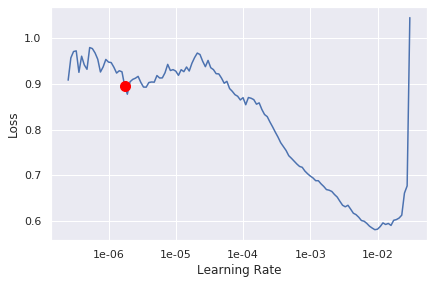

In [65]:
learn.lr_find(start_lr=1e-7, num_it=200, end_lr = 10)
learn.recorder.plot(suggestion=True)

In [125]:
learn.fit_one_cycle(15, max_lr=1e-3, callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.452462,0.319819,0.879421,01:46
1,0.357004,0.293120,0.869320,01:44
2,0.316612,0.291631,0.887072,01:43
3,0.305514,0.296452,0.873129,01:45
4,0.288823,0.317428,0.880159,01:44
5,0.278816,0.276829,0.874278,01:45
6,0.268503,0.275667,0.871373,01:45
7,0.263238,0.275873,0.880876,01:44
8,0.257070,0.268812,0.888375,01:43
9,0.244963,0.277952,0.893958,01:45


In [32]:
best_model_idx = 9
best_model = 'bestmodel_'+model_name+'_'+str(sz)+'_mse_p2_'+str(best_model_idx)

In [33]:
learn.load(best_model)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
4.0,4.0,4.0,0.0,0.0
Path: .;

Valid: LabelList (733 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
0.0,0.0,0.0,2.0,0.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=

In [34]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [35]:
sample_df = pd.read_csv('sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [36]:
learn.data.add_test(MyImageItemList.from_df(sample_df,'./',folder='2019data/test_images',suffix='.png'))

In [37]:
preds,y = learn.get_preds(DatasetType.Test)
coefficients = [0.5, 1.5, 2.5, 3.5]
optR = OptimizedRounder()
test_predictions = optR.predict(preds, coefficients)

In [38]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head(20)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0


In [39]:
sample_df.to_csv('submission.csv',index=False)

In [40]:
# del learn_test
print(gc.collect())

22
